In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import lib.toy_data as toy_data
import lib.layers as layers

from train_misc import build_model_tabular
from train_misc import create_regularization_fns

import argparse

In [19]:
parser = argparse.ArgumentParser('FFJORD-TAP-SGM')
parser.add_argument(
    '--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'],
    type=str, default='moons'
)


parser.add_argument('--depth', help='number of hidden layers of score network', type=int, default=7)
parser.add_argument('--dims', type = int,default = 64)
parser.add_argument('--hiddenunits',type = int, default = 32)
parser.add_argument('--niters', type=int, default=100001)
parser.add_argument('--batch_size', type=int, default=256)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--save', type=str, default='experiments/ffjord')
parser.add_argument('--tint',type = float, default = 0.05)
parser.add_argument('--finalT',type = float, default = 0.5)
parser.add_argument('--dt',type = float,default = 0.001)
parser.add_argument('--rff',type = bool, default = False)
parser.add_argument('--gpu', type=int, default=0)

args = parser.parse_args('')

In [21]:
## load scorenets
args.dataset = 'checkerboard'
args.dims = 16
model_location = '../../ffjord-master/experiments/ffjord/'+args.dataset + str(args.dims)+'/checkpt.pth'
checkpoint = torch.load(model_location)
preconditionerargs = checkpoint['args']
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
regularization_fns, regularization_coeffs = create_regularization_fns(preconditionerargs)
model = build_model_tabular(preconditionerargs, 2, regularization_fns)
model.load_state_dict(checkpoint['state_dict'])

scorenet = torch.load('experiments/ffjord/checkerboard_dims16_scoredepth7_T0.3_tint0.05_FF/scorenet')
B = torch.load('experiments/ffjord/checkerboard_dims16_scoredepth7_T0.3_tint0.05_FF/FF_B')
c = torch.load('experiments/ffjord/checkerboard_dims16_scoredepth7_T0.3_tint0.05_FF/FF_c')




In [61]:
def FF_reverse_sde_corrector(score, init,T,B,c,lr=args.dt):
    step = int(T/lr) 
    for i in range(step,0,-1):
        current_lr = lr


        FFinit = torch.matmul(init,B) + c
        # checkbounds = (torch.abs(init[:,0])<3).type(torch.uint8) * (torch.abs(init[:,1])<3)
        # FFinit = torch.multiply( checkbounds.reshape(-1,1) , torch.cos(FFinit) )
        FFinit = torch.cos(FFinit) 
        # FFinit = torch.cat( (torch.cos(FFinit), torch.sin(FFinit)),1 )
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(FFinit.shape[0],1),FFinit),1)


        init = init + current_lr  * (init/2 +( -init + score(evalpoint).detach() ))
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
        for jj in range(0):
            FFinit = torch.cos(torch.matmul(init,B) + c)
            evalpoint = torch.cat(((torch.tensor(lr*(i-1))).repeat(FFinit.shape[0],1),FFinit),1)
            init = init + current_lr * (init/2 + (-init + score(evalpoint).detach()))+ torch.randn_like(init) * np.sqrt(current_lr)

        if i == 1:
            for jj  in range(1000):
                FFinit = torch.cos(torch.matmul(init,B) + c)
                evalpoint = torch.cat(((torch.tensor(lr*(i-1))).repeat(FFinit.shape[0],1),FFinit),1)
                init = init + current_lr * (init/2 + (-init + score(evalpoint).detach()))+ torch.randn_like(init) * np.sqrt(current_lr)
           


    return init



In [62]:
T = 0.3
samples_lang = torch.randn(10000, 2) # * (right_bound - left_bound) + left_bound
    # samples_lang = reverse_sde(scorenet, samples_lang,torch.tensor(T)).detach().numpy()
samples_lang = FF_reverse_sde_corrector(scorenet, samples_lang,torch.tensor(T),B,c).detach().numpy()
samples_lang_target = model(torch.tensor(samples_lang),None,reverse = True).detach().numpy()


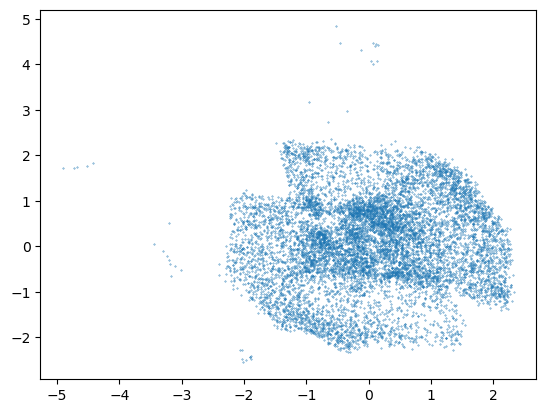

In [63]:
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)

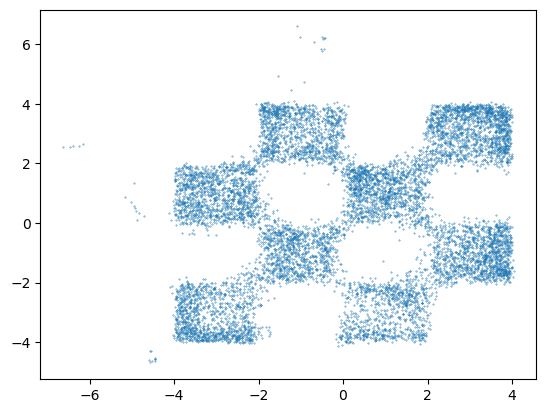

In [64]:
plt.scatter(samples_lang_target[:,0],samples_lang_target[:,1],s = 0.1)